In [1]:
!wget https://www.dropbox.com/s/heng5xqux194qco/Eye_cataract_dataset.zip?dl=0

--2020-12-15 17:18:54--  https://www.dropbox.com/s/heng5xqux194qco/Eye_cataract_dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/heng5xqux194qco/Eye_cataract_dataset.zip [following]
--2020-12-15 17:18:54--  https://www.dropbox.com/s/raw/heng5xqux194qco/Eye_cataract_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf7adb4dd63c47c434ad2566aa8.dl.dropboxusercontent.com/cd/0/inline/BFKX53roZvXVBMaj_qfYmWzEsDcZsSQCYFbOufJRjjubavM3h-n-QG0anW_GWbcwhEtc8VXNwMsqBdaxKNOYeetILHfTyZZizHYrvT7zBTCxssxcJ1Avd1jtx91b4_Z-SYc/file# [following]
--2020-12-15 17:18:55--  https://ucf7adb4dd63c47c434ad2566aa8.dl.dropboxusercontent.com/cd/0/inline/BFKX53roZvXVBMaj_qfYmWzEsDcZsSQCYFbOufJRjjubavM3h-n-QG0anW_GWbcwhEt

In [2]:
!unzip Eye_cataract_dataset.zip?dl=0 -d "data/"

Streaming output truncated to the last 5000 lines.
  inflating: data/preprocessed_images/2179_left.jpg  
  inflating: data/preprocessed_images/2179_right.jpg  
  inflating: data/preprocessed_images/217_left.jpg  
  inflating: data/preprocessed_images/217_right.jpg  
  inflating: data/preprocessed_images/2180_left.jpg  
  inflating: data/preprocessed_images/2180_right.jpg  
  inflating: data/preprocessed_images/2181_left.jpg  
  inflating: data/preprocessed_images/2181_right.jpg  
  inflating: data/preprocessed_images/2182_left.jpg  
  inflating: data/preprocessed_images/2182_right.jpg  
  inflating: data/preprocessed_images/2183_left.jpg  
  inflating: data/preprocessed_images/2183_right.jpg  
  inflating: data/preprocessed_images/2184_left.jpg  
  inflating: data/preprocessed_images/2184_right.jpg  
  inflating: data/preprocessed_images/2185_left.jpg  
  inflating: data/preprocessed_images/2185_right.jpg  
  inflating: data/preprocessed_images/2187_left.jpg  
  inflating: data/preproc

In [3]:
import numpy as np
import cv2
import os 
import pandas as pd
from random import sample

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix as plt_con_mat

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model

In [4]:
path = "../input/ocular-disease-recognition-odir5k"
df = pd.read_csv('/content/data/full_df.csv')
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
file_names = []
labels = []

for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["C"], df["Left-Fundus"]):
    
    if(("cataract" in text) and (label == 1)):
        file_names.append(file_name)
        labels.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names.append(file_name)
        labels.append(0)
        
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["C"], df["Right-Fundus"]):
    
    if(("cataract" in text) and (label == 1)):
        file_names.append(file_name)
        labels.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names.append(file_name)
        labels.append(0)

print(len(file_names), len(labels))

6162 6162


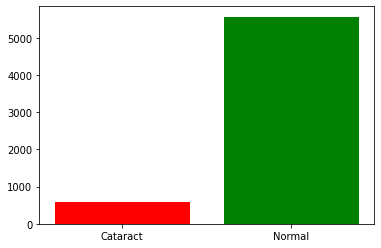

In [6]:
plt.bar([0,1], [len([i for i in labels if i == 1]), len([i for i in labels if i == 0])], color = ['r', 'g'])
plt.xticks([0, 1], ['Cataract', 'Normal'])
plt.show()

In [7]:
ROW = 224
COL = 224

In [8]:
from keras.preprocessing import image

In [9]:
image_data = []
for idx, image_name in enumerate(file_names):
    try:
      img = image.load_img(os.path.join('/content/data/preprocessed_images',image_name),target_size=(224,224))
      imgs=image.img_to_array(img)
      image_data.append(imgs)
    except:
      if idx<=len(labels):
        del labels[idx]
      pass
#image_data = np.array(image_data)
#print(image_data.shape)

In [10]:
print(len(image_data))
#print(image_data[0].shape)
print(image_data[0].shape)
image_data=np.array(image_data)

6078
(224, 224, 3)


In [11]:
temp = []
for idx, label in enumerate(labels):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data[idx])
    y_data.append(labels[idx])

temp = []
for idx, label in enumerate(labels):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data[idx])
    y_data.append(labels[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

print(X_data.shape, y_data.shape)


(1178, 224, 224, 3) (1178, 2)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(942, 224, 224, 3) (942, 2)
(236, 224, 224, 3) (236, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


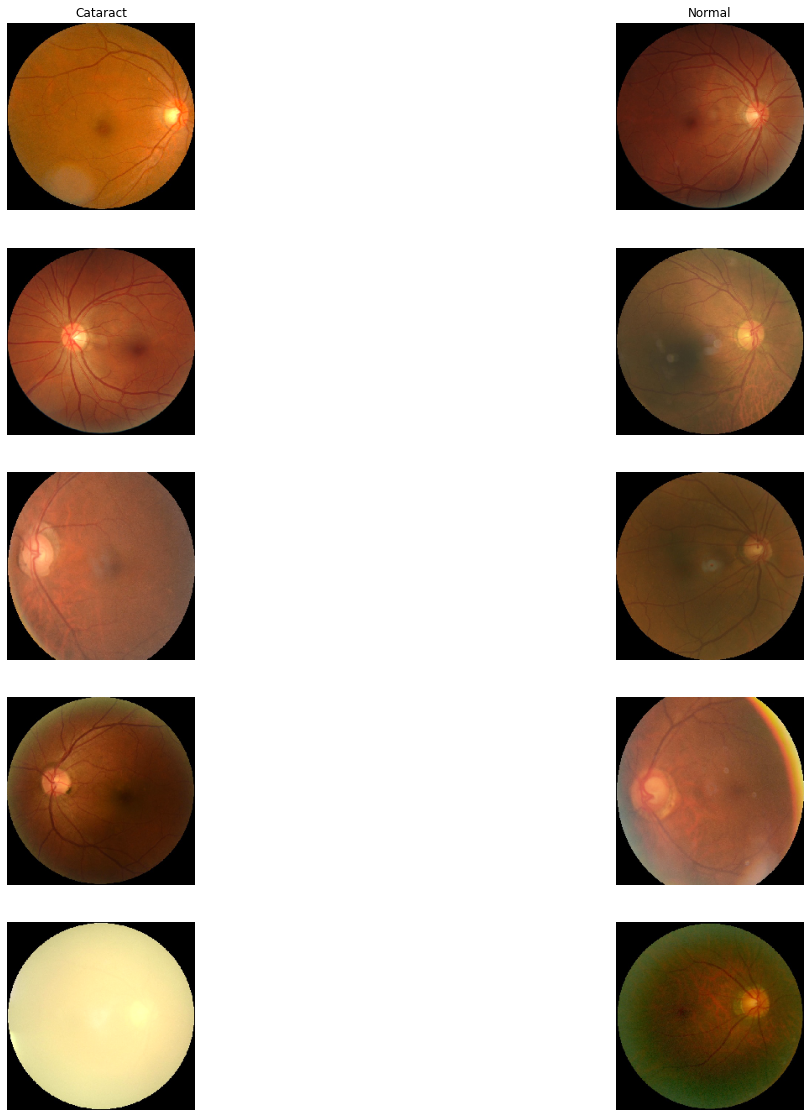

In [13]:
c = 0
n = 0

cataract_images = []
normal_images = []

for idx, label in enumerate(y_data):

    if(n <= 5 and np.argmax(label) == 0):
        normal_images.append(idx)
        n += 1
    elif(c <= 5):
        cataract_images.append(idx)
        c += 1
        
    if(n == 5 and c == 5):
        break
        
fig, ax = plt.subplots(5, 2, figsize = (20, 20))

ax[0, 0].title.set_text("Cataract")
ax[0, 1].title.set_text("Normal")

for i in range(5):
    
    ax[i, 0].imshow(X_data[cataract_images[i]]/225.0)
    ax[i, 0].axis('off')
    ax[i, 1].imshow(X_data[normal_images[i]]/255.0)
    ax[i, 1].axis('off')

plt.show()

In [14]:
vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(ROW, COL, 3))
for layer in vgg.layers:
    layer.trainable = False

80142336/80134624 [==============================] - 2s 0us/step


In [15]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2,activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 21,630,210
Trainable params: 1,605,826
Non-trainable params: 20,024,384
_________________________________________________________________


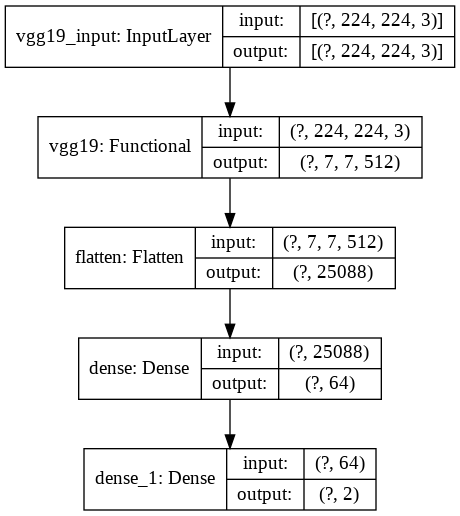

In [16]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 15,
                    batch_size = 64)

Epoch 1/15
15/15 [==============================] - 18s 1s/step - loss: 6.4105 - accuracy: 0.7495 - precision: 0.7495 - recall: 0.7495 - val_loss: 0.5970 - val_accuracy: 0.9110 - val_precision: 0.9110 - val_recall: 0.9110
Epoch 2/15
15/15 [==============================] - 10s 657ms/step - loss: 0.8869 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - val_loss: 0.3842 - val_accuracy: 0.8686 - val_precision: 0.8686 - val_recall: 0.8686
Epoch 3/15
15/15 [==============================] - 10s 654ms/step - loss: 0.2824 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - val_loss: 0.3157 - val_accuracy: 0.8814 - val_precision: 0.8814 - val_recall: 0.8814
Epoch 4/15
15/15 [==============================] - 10s 655ms/step - loss: 0.2025 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - val_loss: 0.2922 - val_accuracy: 0.8686 - val_precision: 0.8686 - val_recall: 0.8686
Epoch 5/15
15/15 [==============================] - 10s 653ms/step - loss: 0.1577 - accuracy: 0.9427 - 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

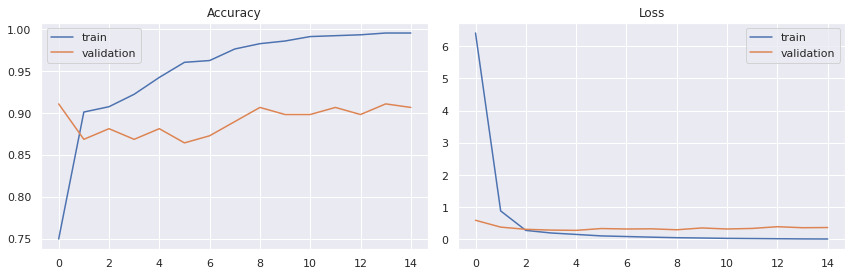

In [18]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label = 'train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label = 'validation')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label = 'train')
sns.lineplot(history.epoch, history.history['val_loss'], label = 'validation')
plt.title('Loss')
plt.tight_layout()

#plt.savefig('epoch_history.png')
plt.show()


In [23]:
preds = model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=1)
#plt.figure(figsize=(14,14))
#plt_con_mat(model,y_true, preds)
#plt.show()

In [37]:
label_dict={'1':'Cataract','0':'non cataract'}

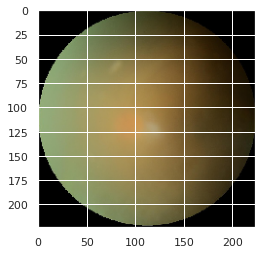

predictions :  Cataract
Actual : Cataract


In [39]:
plt.imshow(X_test[0]/255.0)
plt.show()
print('predictions :  '+label_dict[str(preds[0])])
print('Actual : '+label_dict[str(np.argmax(y_test[0]))])

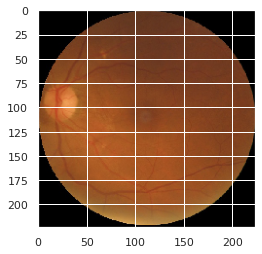

predictions :  non cataract
Actual : non cataract


In [40]:
plt.imshow(X_test[5]/255.0)
plt.show()
print('predictions :  '+label_dict[str(preds[5])])
print('Actual : '+label_dict[str(np.argmax(y_test[5]))])

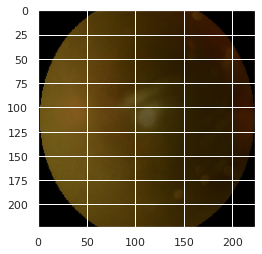

predictions :  Cataract
Actual : Cataract


In [41]:
plt.imshow(X_test[10]/255.0)
plt.show()
print('predictions :  '+label_dict[str(preds[10])])
print('Actual : '+label_dict[str(np.argmax(y_test[10]))])